### Scene Classification
+ Dataset Source - Kaggle Dataset


#### Implementation of CNN-based background classification model and utilization of Grad cam (XAI) 

+ 데이터 로드

In [1]:
import pandas as pd
data = pd.read_csv('train-scene/train.csv')

In [2]:
data.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


In [3]:
data.isna().sum()

image_name    0
label         0
dtype: int64

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17034 entries, 0 to 17033
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  17034 non-null  object
 1   label       17034 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 266.3+ KB


In [5]:
data['label'] = data['label'].astype('str')

In [6]:
label_dict = {
    0 : 'Buildings',
    1 : 'Forests',
    2 : 'Glacier',
    3 : 'Mountains',
    4 : 'Sea',
    5 : 'Street'}

+ 데이터 비율 확인

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize = (10, 4))
sns.countplot(x ='label', data=data)
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.show() 

<Figure size 1000x400 with 1 Axes>

+ Image 파일 압축 해제 및 로드

In [8]:
!unzip -uq "./train-scene/train_image/image_zip/train.zip" -d "./train-scene/train_image/"

In [9]:
import os
image_path = 'train-scene/train_image/'
image_dir = os.listdir(image_path)
image_dir = [jpg for jpg in image_dir if jpg.endswith('.jpg')]

+ Image 개수 확인

In [10]:
len(image_dir)

24335

+ 라벨 없는 Image 삭제

In [11]:
for f_name in image_dir:
    if f_name in data['image_name'].tolist():
        pass
    else:
        os.remove(image_path+f_name)

In [12]:
image_dir = os.listdir(image_path)
image_dir = [jpg for jpg in image_dir if jpg.endswith('.jpg')]
len(image_dir)

17034

+ Image 데이터 확인

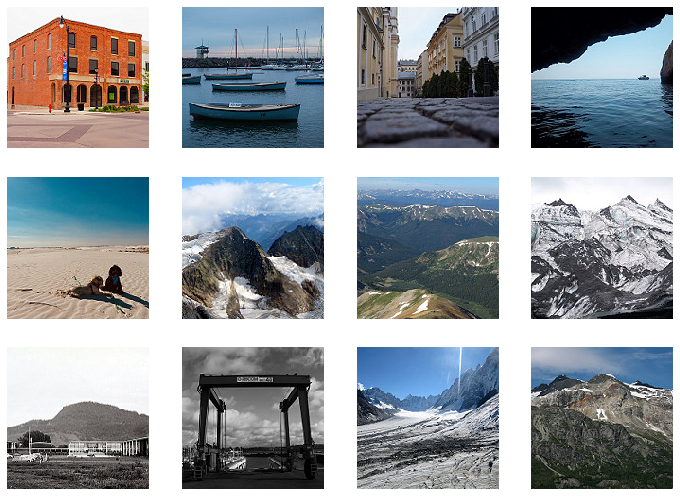

In [13]:
import matplotlib.image as mpimg

nrows, ncols = 4, 4
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols*3, nrows*3)

check_image = [os.path.join(image_path, file) for file in image_dir[0:12]]

for idx, img_path in enumerate(check_image):
    sp = plt.subplot(nrows, ncols, idx + 1)
    sp.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)
    
plt.show()

+ Train, Test 분할

In [14]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.2, random_state=22)
print(train_data.shape)
print(test_data.shape)

(13627, 2)
(3407, 2)


+ Train, Test 이미지 디렉토리 분할

In [15]:
mk_dir = ['train_set', 'test_set']
for i in mk_dir:
    if not os.path.exists(image_path+i):
        os.makedirs(image_path+i)

In [16]:
for f_name in train_data['image_name'].tolist():
    os.replace(image_path + f_name, image_path+'train_set/' + f_name)

In [17]:
for f_name in test_data['image_name'].tolist():
    os.replace(image_path + f_name, image_path+'test_set/' + f_name)

+ 이미지 전처리

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1.0/255.)
test_datagen  = ImageDataGenerator(rescale=1.0/255.)

In [20]:
train_gen=train_datagen.flow_from_dataframe(dataframe = train_data,
                                      directory=image_path+'train_set',
                                      batch_size=20,
                                      class_mode="categorical",
                                      x_col="image_name",
                                      color_mode="rgb",
                                      y_col="label",
                                      target_size=(150,150)) 

Found 13627 validated image filenames belonging to 6 classes.


In [21]:
valid_gen=test_datagen.flow_from_dataframe(dataframe = test_data,
                                      directory=image_path+'test_set',
                                      batch_size=20,
                                      class_mode="categorical",
                                      x_col="image_name",
                                      color_mode="rgb",
                                      y_col="label",
                                      target_size=(150,150))

Found 3407 validated image filenames belonging to 6 classes.


+ CNN Classification 모델 생성

In [22]:
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Input, MaxPooling2D, Conv2D
import tensorflow as tf

In [23]:
def cnn_model_network(input_shape=(150, 150, 3), y_data=None, optimizer=None):
    inp = Input(shape=(input_shape))
    conv = Conv2D(16, (3,3), activation='relu')(inp)
    pool = MaxPooling2D(2,2)(conv)
    conv = Conv2D(32, (3,3), activation='relu')(pool)
    pool = MaxPooling2D(2,2)(conv)
    conv = Conv2D(64, (3,3), activation='relu')(pool)
    pool = MaxPooling2D(2,2)(conv)                                            
    flat = Flatten()(pool)
    dense = Dense(512, activation='relu')(flat)
    out = Dense(y_data, activation='softmax')(dense)

    cnn_model = Model(inputs=inp, outputs=out)

    cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                      metrics=['categorical_crossentropy', 'accuracy', Precision(), Recall()])

    return cnn_model

In [24]:
cnn_model = cnn_model_network(y_data = len(train_data['label'].unique()), optimizer='Adam')

In [25]:
cnn_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0     

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

cnn_classification = cnn_model
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1, min_delta=0.001)
ai_history = cnn_classification.fit(train_gen, validation_data=valid_gen, epochs=30, batch_size=16, shuffle=True, verbose=1, callbacks=[early_stop])

Epoch 1/30
682/682 [==============================] - 24s 31ms/step - loss: 1.1087 - categorical_crossentropy: 1.1087 - accuracy: 0.5659 - precision: 0.6999 - recall: 0.3942 - val_loss: 0.6258 - val_categorical_crossentropy: 0.6258 - val_accuracy: 0.7781 - val_precision: 0.8321 - val_recall: 0.6983
Epoch 2/30
682/682 [==============================] - 20s 30ms/step - loss: 0.5788 - categorical_crossentropy: 0.5788 - accuracy: 0.7842 - precision: 0.8251 - recall: 0.7365 - val_loss: 0.5834 - val_categorical_crossentropy: 0.5834 - val_accuracy: 0.7834 - val_precision: 0.8203 - val_recall: 0.7490
Epoch 3/30
682/682 [==============================] - 20s 29ms/step - loss: 0.4120 - categorical_crossentropy: 0.4120 - accuracy: 0.8506 - precision: 0.8761 - recall: 0.8248 - val_loss: 0.5738 - val_categorical_crossentropy: 0.5738 - val_accuracy: 0.8028 - val_precision: 0.8252 - val_recall: 0.7787
Epoch 4/30
682/682 [==============================] - 20s 29ms/step - loss: 0.2591 - categorical_cro

+ 모델 accracy 및 loss 그래프 출력

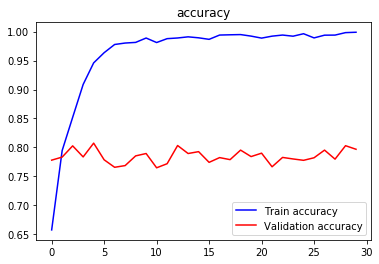

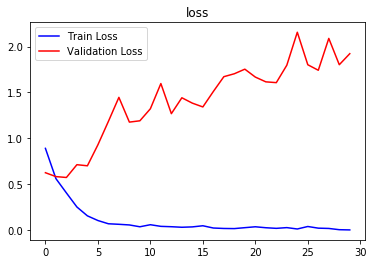

In [27]:
import matplotlib.pyplot as plt

acc = ai_history.history['accuracy']
val_acc = ai_history.history['val_accuracy']
loss = ai_history.history['loss']
val_loss = ai_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', color='b', label='Train accuracy')
plt.plot(epochs, val_acc, 'b', color='r', label='Validation accuracy')
plt.title('accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'g', color='b', label='Train Loss')
plt.plot(epochs, val_loss, 'g', color='r', label='Validation Loss')
plt.title('loss')
plt.legend()

plt.show()

+ 예측 이미지 Load

In [28]:
def target_test_function(target_images=None, mode=None):
    nrows, ncols = 4, 4
    pic_index = 0

    fig = plt.gcf()
    fig.set_size_inches(ncols*3, nrows*3)

    check_image = [os.path.join(image_path + mode + '_set/', file) for file in target_images]

    for idx, img_path in enumerate(check_image):
        sp = plt.subplot(nrows, ncols, idx + 1)
        sp.axis('Off')

        img = mpimg.imread(img_path)
        plt.imshow(img)

    plt.show()

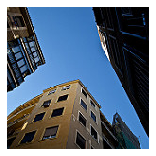

In [106]:
from keras.preprocessing import image
import numpy as np

target_images=test_data[test_data.label=='0'].sample(1)['image_name'].tolist()
target_test_function(target_images, mode='test')

for target in target_images:
    target_path = image_path + 'test_set/' + target
    target_img = image.load_img(target_path, target_size=(150, 150))
    target_x = image.img_to_array(target_img)
    target_x = np.expand_dims(target_x, axis=0)
    target_x = np.vstack([target_x])

+ 이미지 예측 결과

In [107]:
label_dict[cnn_classification.predict(target_x, batch_size=8).argmax(axis=1)[0]]

'Buildings'

+ eXplainable AI 적용 (Using Grad Cam)

In [114]:
model = cnn_model
last_conv_layer = model.get_layer("conv2d_11")
last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

In [115]:
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])

In [116]:
x = classifier_input
for layer_name in ["max_pooling2d_11", "flatten_3", "dense_6", "dense_7"]:
    x = model.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

In [117]:
with tf.GradientTape() as tape:
    inputs = target_x
    last_conv_layer_output = last_conv_layer_model(inputs)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

In [118]:
grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [119]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

In [120]:
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

In [121]:
import cv2
# Average over all the filters to get a single 2D array
gradcam = np.mean(last_conv_layer_output, axis=-1)
# Clip the values (equivalent to applying ReLU)
# and then normalise the values
gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
gradcam = cv2.resize(gradcam, (150, 150))

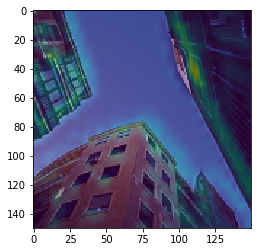

In [122]:
plt.imshow(np.array(target_img))
plt.imshow(gradcam, alpha=0.5)

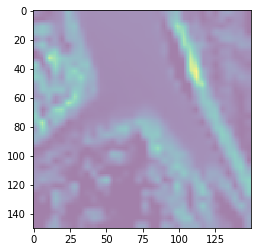

In [123]:
plt.imshow(gradcam, alpha=0.5)